In [ ]:
# Load your dataset
import pandas as pd
df = pd.read_csv("/content/llm_outputs_ollama_with_time.csv")
df['label_encoded'] = pd.Categorical(df['Used LLM']).codes


In [ ]:
!pip install torch==2.2.0 transformers==4.42.4 sentence-transformers==2.7.0 pandas scikit-learn
!pip install datasets
!pip install flash_attn


In [ ]:
import torch
from sentence_transformers import SentenceTransformer


# Load the Stella model
model = SentenceTransformer("dunzhang/stella_en_1.5B_v5", trust_remote_code=True).cuda()

# Set the model sequence length
model.max_seq_length = 512  # Maximum sequence length supported by the model


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/174k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

RuntimeError: Failed to import transformers.models.chameleon.configuration_chameleon because of the following error (look up to see its traceback):
No module named 'transformers.models.chameleon.configuration_chameleon'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs[1]  # CLS token's output
        out = self.fc(cls_output)
        return out


In [ ]:
##NN classifier
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define a dataset class
class LLMClassifierDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float32),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Define the neural network model
class LLMClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LLMClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

# Prepare data
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_embeddings, df['label_encoded'].tolist(), test_size=0.2, random_state=42)

# Create dataset and dataloader
train_dataset = LLMClassifierDataset(X_train, y_train)
test_dataset = LLMClassifierDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
from transformers import BertTokenizer, BertModel, AdamW

# Initialize the model, loss function, and optimizer
# model_classifier = BERTClassifier(num_classes=len(df['label_encoded'].unique()))

model_classifier = LLMClassifier(input_size=2048, num_classes=len(df['label_encoded'].unique()))  # Input size = 2048 (two 1024-dimensional embeddings concatenated)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_classifier.parameters(), lr=1e-4)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_classifier.to(device)


LLMClassifier(
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=6, bias=True)
  )
)

<ipython-input-12-fb6b4e1104a2>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float32),


Epoch 1, Loss: 0.9590461246867975
Epoch 2, Loss: 0.5909971048583587
Epoch 3, Loss: 0.5049030164188395
Epoch 4, Loss: 0.46161705132201314
Epoch 5, Loss: 0.4344852385893464
Epoch 6, Loss: 0.4151497087329626
Epoch 7, Loss: 0.40042777959691983
Epoch 8, Loss: 0.3878069570722679
Epoch 9, Loss: 0.3774289210420102
Epoch 10, Loss: 0.368410297545294


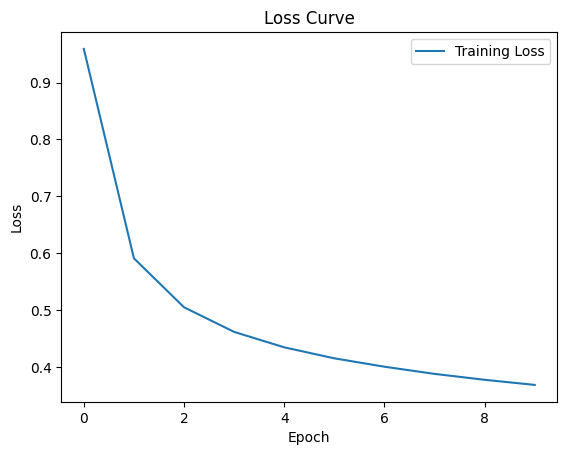

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curve(train_losses):
    plt.plot(train_losses, label="Training Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

# Modify the training function to capture loss at each epoch
def train_with_loss_tracking(model, train_loader, optimizer, loss_fn, epochs=10):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss}")

    plot_loss_curve(train_losses)

# Train the model and plot the loss curve
train_with_loss_tracking(model_classifier, train_loader, optimizer, loss_fn)


<ipython-input-12-fb6b4e1104a2>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float32),


Epoch 1, Accuracy: 87.21%
Epoch 2, Accuracy: 87.50%
Epoch 3, Accuracy: 87.68%
Epoch 4, Accuracy: 88.03%
Epoch 5, Accuracy: 88.16%
Epoch 6, Accuracy: 88.28%
Epoch 7, Accuracy: 88.55%
Epoch 8, Accuracy: 88.63%
Epoch 9, Accuracy: 88.90%
Epoch 10, Accuracy: 88.99%


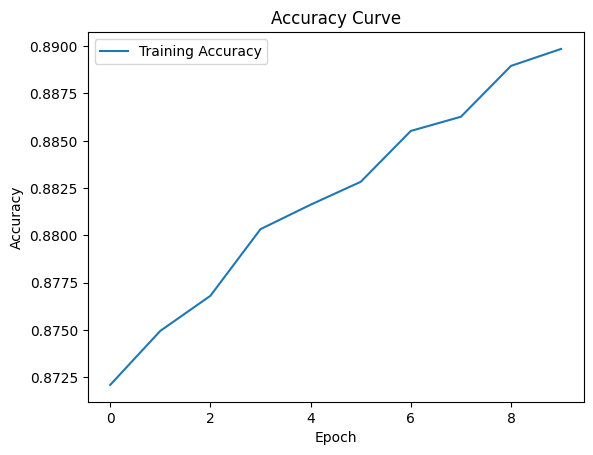

In [ ]:
def plot_accuracy_curve(train_accuracies):
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

# Modify the training function to capture accuracy at each epoch
def train_with_accuracy_tracking(model, train_loader, optimizer, loss_fn, epochs=10):
    model.train()
    train_accuracies = []

    for epoch in range(epochs):
        correct = 0
        total = 0
        for batch in train_loader:
            optimizer.zero_grad()
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Accuracy: {train_accuracy * 100:.2f}%")

    plot_accuracy_curve(train_accuracies)

# Train the model and plot accuracy curve
train_with_accuracy_tracking(model_classifier, train_loader, optimizer, loss_fn)


In [ ]:
# Training function
def train(model, train_loader, optimizer, loss_fn, epochs=5+5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()

            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Train the model
train(model_classifier, train_loader, optimizer, loss_fn)


<ipython-input-6-fb6b4e1104a2>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float32),


Epoch 1, Loss: 0.9631579758524895
Epoch 2, Loss: 0.5902676541656255
Epoch 3, Loss: 0.5043138159091274
Epoch 4, Loss: 0.46115045645460484
Epoch 5, Loss: 0.4344021036575238
Epoch 6, Loss: 0.4145336861560742
Epoch 7, Loss: 0.399610972913603
Epoch 8, Loss: 0.38688929856568577
Epoch 9, Loss: 0.37605165522545575
Epoch 10, Loss: 0.36630442160181703


<ipython-input-12-fb6b4e1104a2>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float32),


Test Accuracy: 84.68%


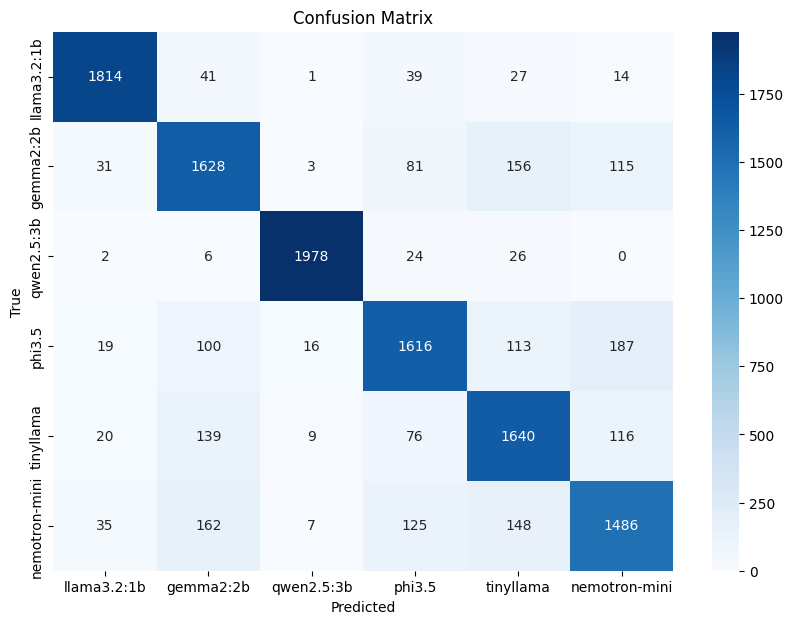

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, pred_labels, classes):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Update evaluate function to return true and predicted labels
def evaluate_and_plot_cm(model, test_loader, class_names):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    plot_confusion_matrix(all_labels, all_preds, class_names)

# Pass the class names (encoded labels)
class_names = list(df['Used LLM'].unique())  # Assuming 'Used LLM' column has original class names
evaluate_and_plot_cm(model_classifier, test_loader, class_names)


<ipython-input-12-fb6b4e1104a2>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float32),


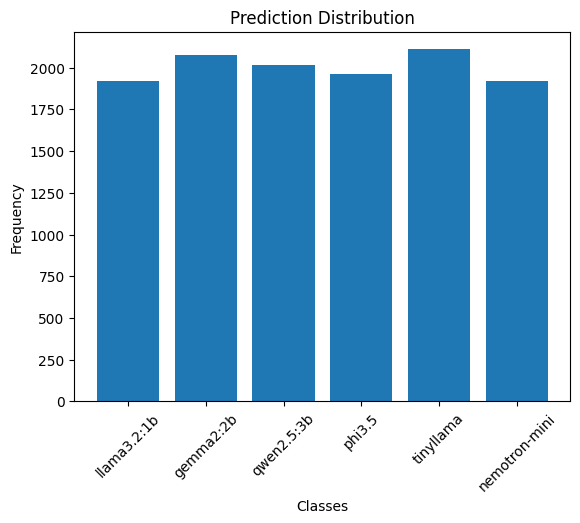

In [ ]:
import numpy as np

def plot_predictions_distribution(pred_labels, class_names):
    unique, counts = np.unique(pred_labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique, class_names, rotation=45)
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.title('Prediction Distribution')
    plt.show()

# Modify evaluate function to return predicted labels for distribution plot
def evaluate_and_plot_preds(model, test_loader, class_names):
    model.eval()
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            _, preds = torch.max(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())

    plot_predictions_distribution(all_preds, class_names)

# Plot the prediction distribution
evaluate_and_plot_preds(model_classifier, test_loader, class_names)


In [ ]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            embeddings = batch['embeddings'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(embeddings)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Evaluate the model
evaluate(model_classifier, test_loader)


<ipython-input-6-fb6b4e1104a2>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'embeddings': torch.tensor(self.embeddings[idx], dtype=torch.float32),


Test Accuracy: 84.61%


Epoch 1, Loss: 0.6870, Accuracy: 78.21%
Epoch 2, Loss: 0.3565, Accuracy: 87.98%
Epoch 3, Loss: 0.2739, Accuracy: 90.65%


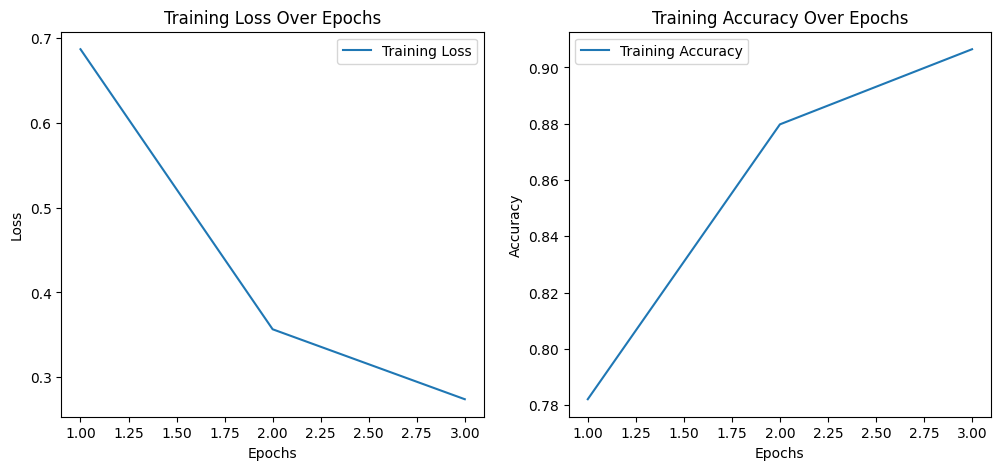

In [ ]:
#BERT classifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the BERT-based classifier with selective layer fine-tuning
class BERTClassifier(nn.Module):
    def __init__(self, num_classes, fine_tune_layers=2):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Linear(self.bert.config.hidden_size * 2, num_classes)  # Multiply by 2 to handle concatenation of two embeddings

        # Freeze all BERT layers first
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze the last `fine_tune_layers` layers of BERT
        for param in self.bert.encoder.layer[-fine_tune_layers:].parameters():
            param.requires_grad = True

    def forward(self, input_ids_prompt, attention_mask_prompt, input_ids_output, attention_mask_output):
        # Encode the Input Prompt and LLM Output separately
        prompt_output = self.bert(input_ids_prompt, attention_mask=attention_mask_prompt)[1]  # CLS token output
        output_output = self.bert(input_ids_output, attention_mask=attention_mask_output)[1]  # CLS token output

        # Concatenate the embeddings of Input Prompt and LLM Output
        combined_output = torch.cat((prompt_output, output_output), dim=1)

        # Pass through the classifier
        out = self.fc(combined_output)
        return out

# Dataset preparation
class LLMTextDataset(Dataset):
    def __init__(self, prompts, outputs, labels, tokenizer, max_len):
        self.prompts = prompts
        self.outputs = outputs
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, idx):
        prompt = self.prompts[idx]
        output = self.outputs[idx]
        label = self.labels[idx]
        # Tokenize both Input Prompt and LLM Output separately, handling potential NaN values
        prompt = str(prompt) if pd.notna(prompt) else "[UNK]"  # Replace NaN with [UNK]
        output = str(output) if pd.notna(output) else "[UNK]"  # Replace NaN with [UNK]

        # Tokenize both Input Prompt and LLM Output separately
        prompt_encoding = self.tokenizer.encode_plus(
            prompt,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        output_encoding = self.tokenizer.encode_plus(
            output,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids_prompt': prompt_encoding['input_ids'].flatten(),
            'attention_mask_prompt': prompt_encoding['attention_mask'].flatten(),
            'input_ids_output': output_encoding['input_ids'].flatten(),
            'attention_mask_output': output_encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load your dataset
df = pd.read_csv("/content/llm_outputs_ollama_with_time.csv")
df['label_encoded'] = pd.Categorical(df['Used LLM']).codes  # Encode the labels
prompts = df['Input Prompt'].tolist()
outputs = df['LLM Output'].tolist()
labels = df['label_encoded'].tolist()

# Split the data
X_train_prompts, X_test_prompts, X_train_outputs, X_test_outputs, y_train, y_test = train_test_split(
    prompts, outputs, labels, test_size=0.2, random_state=42)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Hyperparameters
MAX_LEN = 128
BATCH_SIZE = 64
EPOCHS = 3
NUM_CLASSES = len(df['label_encoded'].unique())
LEARNING_RATE = 2e-5

# Create DataLoader for training and testing
train_dataset = LLMTextDataset(X_train_prompts, X_train_outputs, y_train, tokenizer, MAX_LEN)
test_dataset = LLMTextDataset(X_test_prompts, X_test_outputs, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialize model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BERTClassifier(num_classes=NUM_CLASSES, fine_tune_layers=4).to(device)  # Fine-tune the last 4 layers
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_fn = nn.CrossEntropyLoss()

# Training loop with selective layer fine-tuning, with loss and accuracy printing
# You can modify your train loop to store losses and accuracies for plotting
train_losses = []
train_accuracies = []

def train_with_plotting(model, train_loader, optimizer, loss_fn, epochs=EPOCHS):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids_prompt = batch['input_ids_prompt'].to(device)
            attention_mask_prompt = batch['attention_mask_prompt'].to(device)
            input_ids_output = batch['input_ids_output'].to(device)
            attention_mask_output = batch['attention_mask_output'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids_prompt, attention_mask_prompt, input_ids_output, attention_mask_output)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loss.backward()
            optimizer.step()

        # Calculate and store epoch loss and accuracy
        train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Epoch {epoch + 1}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}%")

# Call the function to train and collect data for plotting
train_with_plotting(model, train_loader, optimizer, loss_fn, epochs=EPOCHS)

# Plot loss and accuracy over epochs
def plot_training_metrics(train_losses, train_accuracies):
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()

    plt.show()

# Call the plot function after training
plot_training_metrics(train_losses, train_accuracies)

# Evaluation loop
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids_prompt = batch['input_ids_prompt'].to(device)
            attention_mask_prompt = batch['attention_mask_prompt'].to(device)
            input_ids_output = batch['input_ids_output'].to(device)
            attention_mask_output = batch['attention_mask_output'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids_prompt, attention_mask_prompt, input_ids_output, attention_mask_output)
            _, preds = torch.max(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    return all_labels, all_preds

# Plot confusion matrix
def plot_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Distribution of predictions
def plot_predictions_distribution(pred_labels):
    unique, counts = np.unique(pred_labels, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.title('Prediction Distribution')
    plt.show()

# Train the model
#train(model, train_loader, optimizer, loss_fn, epochs=EPOCHS)




In [ ]:
model = torch.load('bert_classifier_model.pth')

In [ ]:
# Evaluate the model and get predictions
true_labels, pred_labels = evaluate(model, test_loader)

# Plot confusion matrix and distribution of predictions
plot_confusion_matrix(true_labels, pred_labels)
plot_predictions_distribution(pred_labels)

In [ ]:
def plot_classwise_accuracy(true_labels, pred_labels, class_names):
    cm = confusion_matrix(true_labels, pred_labels)
    class_acc = cm.diagonal() / cm.sum(axis=1)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=class_acc)
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.title('Class-wise Accuracy')
    plt.xticks(rotation=45)
    plt.show()

# Assuming you have class names
class_names = df['Used LLM'].unique()
plot_classwise_accuracy(true_labels, pred_labels, class_names)
